This dataset is based on a real dataset with lots of annotations, which can be browsed in the [METASPACE results web interface](http://alpha.metasp.eu) under the name `MPIB//regenwurm_pos`. Simulated data was generated from it using the same method as in the two [preceding](https://github.com/lomereiter/jupyter-notebooks/blob/master/NNMF.ipynb) [notebooks](
https://github.com/lomereiter/jupyter-notebooks/blob/master/Simulating%20an%20IMS%20dataset%20from%20NMF%20factorization%20of%20real%20data.ipynb).

We start with loading the layers corresponding to the spectral components produced by nonnegative matrix factorization:

In [1]:
import pickle
import os

layers = pickle.load(open(os.path.expanduser("~/simulated_2016_05_04_earthwurm.layers.pkl")))

In [2]:
from pyMSpec.pyisocalc import pyisocalc

# sum formulas should all be normalized so that C5HNS3 is the same as H1S3N1C5
def normalized(sf):
    return str(pyisocalc.parseSumFormula(sf))

# read all sum formulas (without adducts) from the layers
sim_layer_formulas = set()

for layer in layers['layers_list']:
    for sf in layers['layers_list'][layer]['sf_list']:
        sim_layer_formulas.add(normalized(sf['sf_a'].split('+')[0]))

Next we load all molecules from CheBI under 'metabolite' node, using CheBI import script from `alexandrovteam/SM_distributed` repo:

In [4]:
%%time
chebi = set()

import sys
sys.path.append(os.path.expanduser("~/github/SM_distributed/scripts"))
import chebi_importer as ch

filters = [ch.containsElement('C'), ch.hasAverageMassWithinRange(50, 2000)]
for term in ch.ChebiOntology().termsBelow('metabolite', filters):
    chebi.add(normalized(term['sum_formula']))
    
print len(chebi)

8757
CPU times: user 16.8 s, sys: 208 ms, total: 17 s
Wall time: 27.9 s


We create a new directory for all the data and molecular annotation results:

In [14]:
dirname = os.path.expanduser("~/regenwurm_pos_sim0")
if not os.path.exists(dirname):
    os.makedirs(dirname)
os.chdir(dirname)

An individual isotope pattern database is created for this dataset using `+H`, `+K`, and `+Na` as target adducts, as well as a decoy database that uses all other elements as 'impossible' adducts. The computed theoretical centroids correspond to an FTICR instrument with resolution of 250k @ m/z=200.

`ims` tool is available from `alexandrovteam/ims-cpp` (the version used below is at commit `c2764f571b04eb3c1f5794d27a8b9552705a3e5b`)

In [25]:
with open("chebi.txt", "w+") as f:
    for sf in chebi:
        f.write(sf + '\n')

!time ims isocalc chebi.txt --adducts=+H,+K,+Na\
    --decoy-adducts=+He,+Li,+Be,+B,+C,+N,+O,+F,+Ne,+Mg,+Al,+Si,+P,+S,+Cl,+Ar,+Ca,+Sc,+Ti,+V,+Cr,\
+Mn,+Fe,+Co,+Ni,+Cu,+Zn,+Ga,+Ge,+As,+Se,+Br,+Kr,+Rb,+Sr,+Y,+Zr,+Nb,+Mo,+Ru,+Rh,+Pd,+Ag,+Cd,+In,\
+Sn,+Sb,+Te,+I,+Xe,+Cs,+Ba,+La,+Ce,+Pr,+Nd,+Sm,+Eu,+Gd,+Tb,+Dy,+Ho,+Ir,+Th,+Pt,+Os,+Yb,+Lu,+Bi,+Pb,\
+Re,+Tl,+Tm,+U,+W,+Au,+Er,+Hf,+Hg,+Ta\
    chebi_fticr_250k_pos.db --resolution 250000 --instrument fticr

Resolution @ m/z=200: 250000
Generating isotope pattern database for adducts +H, +K, +Na...
|===============================================================| ETA: 0h00m02s
Isotope patterns have been saved to chebi_fticr_250k_pos.db
Generating decoy database using adducts +Ag, +Al, +Ar, +As, +Au, +B, +Ba, +Be, +Bi, +Br, +C, +Ca, +Cd, +Ce, +Cl, +Co, +Cr, +Cs, +Cu, +Dy, +Er, +Eu, +F, +Fe, +Ga, +Gd, +Ge, +He, +Hf, +Hg, +Ho, +I, +In, +Ir, +Kr, +La, +Li, +Lu, +Mg, +Mn, +Mo, +N, +Nb, +Nd, +Ne, +Ni, +O, +Os, +P, +Pb, +Pd, +Pr, +Pt, +Rb, +Re, +Rh, +Ru, +S, +Sb, +Sc, +Se, +Si, +Sm, +Sn, +Sr, +Ta, +Tb, +Te, +Th, +Ti, +Tl, +Tm, +U, +V, +W, +Xe, +Y, +Yb, +Zn, +Zr...
|===============================================================| ETA: 0h01m40s
Isotope patterns have been saved to chebi_fticr_250k_pos.db.decoy
755.03user 1.77system 1:43.40elapsed 731%CPU (0avgtext+0avgdata 573532maxresident)k
0inputs+206360outputs (0major+278870minor)pagefaults 0swaps


Original and simulated datasets are then converted to an internal format accepted by `ims` tool:

In [27]:
!time ims convert ~/metabolomics/14_04_29_Regenwurm_pos_centroid.imzML original.imzb
!time ims convert ~/simulated_2016_05_04_regenwurm.imzML simulated.imzb

dumping chunks sorted by m/z...
merging files...
removing temporary files
done!
31.60user 1.72system 0:37.27elapsed 89%CPU (0avgtext+0avgdata 323612maxresident)k
3553736inputs+4500904outputs (1major+74809minor)pagefaults 0swaps
dumping chunks sorted by m/z...
merging files...
removing temporary files
done!
8.94user 0.96system 0:10.55elapsed 93%CPU (0avgtext+0avgdata 319976maxresident)k
860072inputs+1473328outputs (3major+64221minor)pagefaults 0swaps


Molecular annotation is then performed for the two datasets, and also for both target and decoy databases. 

In all cases using we use ±3 ppm interval for building m/z images from centroided data.

In [29]:
!time bash -c '\
ims detect chebi_fticr_250k_pos.db original.imzb --ppm=3 > original.target.results &&\
ims detect chebi_fticr_250k_pos.db.decoy original.imzb --ppm=3 > original.decoy.results &&\
ims fdr original.target.results original.decoy.results > original.fdr &&\
\
ims detect chebi_fticr_250k_pos.db simulated.imzb --ppm=3 > simulated.target.results &&\
ims detect chebi_fticr_250k_pos.db.decoy simulated.imzb --ppm=3 > simulated.decoy.results'

Computing scores |===============================================| ETA: 0h00m05s
Computing scores |===============================================| ETA: 0h02m10s
Computing scores |===============================================| ETA: 0h00m05s
Computing scores |===============================================| ETA: 0h01m58s
1770.36user 176.43system 4:25.77elapsed 732%CPU (0avgtext+0avgdata 953108maxresident)k
53944inputs+81816outputs (0major+120106701minor)pagefaults 0swaps


Since we know the groundtruth for the simulated data, we can provide `ims fdr` tool with it, so that it will print the true FDR in addition to estimated values:

In [33]:
with open("groundtruth.txt", "w+") as f:
    for layer in layers['layers_list']:
        for ion in layers['layers_list'][layer]['sf_list']:
            sf, adduct = ion['sf_a'].split('+')
            sf = normalized(sf)
            f.write("{},+{}\n".format(sf, adduct))

!ims fdr simulated.target.results simulated.decoy.results --groundtruth=groundtruth.txt > simulated.fdr

In [35]:
import pandas as pd
orig_res = pd.read_csv("original.fdr")
sim_res = pd.read_csv("simulated.fdr")

# to give an idea of how the dataframes look like
sim_res.head(n=20)

,formula,adduct,img,iso,moc,est_fdr,true_fdr,correct
0,H57C32O7N5,+H,1.000,1.000,0.999,0.00000,0.0000,1
1,H13C10O4N3,+H,1.000,0.999,0.999,0.00000,0.0000,1
2,H28C16O,+K,1.000,0.999,0.999,0.00000,0.0000,1
3,H17C9O4N,+H,1.000,0.999,0.999,0.00000,0.0000,1
4,H20C12SO5N4,+Na,1.000,0.999,0.999,0.00000,0.0000,1
5,H53C30O7N5,+Na,1.000,1.000,0.998,0.00667,0.0000,1
6,H84C42PO7N,+K,1.000,1.000,0.998,0.00571,0.0000,1
7,H52C24PO6N,+K,1.000,1.000,0.998,0.00500,0.0000,1
8,H42C25ON2,+K,1.000,1.000,0.998,0.00444,0.0000,1
9,H42C26O7,+H,1.000,1.000,0.998,0.00400,0.0000,1


In [36]:
def top_results(df):
    """
    results with estimated FDR < 0.1 and positive MSM
    """
    fdr = df['fdr'] if 'fdr' in df else df['est_fdr']
    return df[(fdr < 0.1) & (df['img'] * df['iso'] * df['moc'] > 0)]

Now we take top results (defined here as having estimated FDR < 0.1 and MSM > 0) for original and simulated data and then see how they correspond to the groundtruth and each other.

We can see that over half of the groundtruth is annotated, which shows that good performance of the pipeline is obtained in an ideal case, where the data is almost noiseless.

<matplotlib_venn._common.VennDiagram instance at 0x7f9f6be80200>

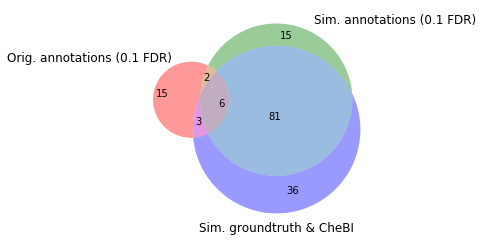

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib_venn import venn3

orig_top = set(top_results(orig_res)['formula'])
sim_top = set(top_results(sim_res)['formula'])
venn3([orig_top, sim_top, sim_layer_formulas & chebi] , 
      ("Orig. annotations (0.1 FDR)", "Sim. annotations (0.1 FDR)", "Sim. groundtruth & CheBI"))

We also compare true and estimated FDR for the simulated dataset, which reveals that there's a room for improvement, but overall the approximation is reasonably good for 0.05–0.1 cutoff.

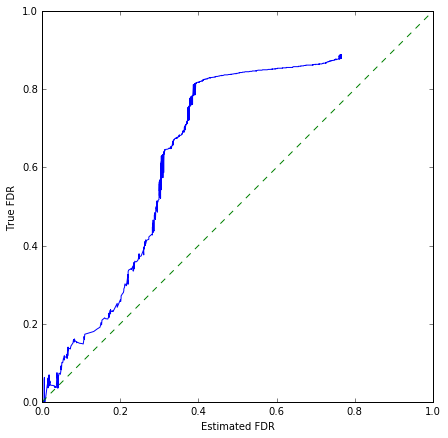

In [40]:
import numpy as np
plt.figure(figsize=(7, 7))
plt.xlabel("Estimated FDR")
plt.ylabel("True FDR")
msm = sim_res['moc'] * sim_res['img'] * sim_res['iso']
est_fdr = sim_res['est_fdr'][msm > 0]
true_fdr = sim_res['true_fdr'][msm > 0]
order = est_fdr.argsort()
est_fdr = est_fdr[order]
true_fdr = true_fdr[order]
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(est_fdr, true_fdr)
plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100), '--')